# 🎓 Analisi dei dati scolastici e modelli predittivi — Student Performance Dataset

## 📌 Introduzione
Questo progetto nasce dall’idea di una startup che sviluppa **soluzioni data-driven** per migliorare le performance scolastiche in aree svantaggiate.  
L’obiettivo è comprendere meglio i bisogni degli studenti e offrire strumenti di supporto personalizzati, utilizzando modelli di **machine learning** applicati a dati reali provenienti da scuole secondarie.

## 📊 Dataset
I dati utilizzati provengono dal **Student Performance Dataset (UCI Machine Learning Repository)** e includono due file:
- `student-mat.csv` → corso di **Matematica**
- `student-por.csv` → corso di **Portoghese (lingua madre)**

Ogni dataset contiene informazioni di tipo:
- **Familiari e sociali** (es. dimensione della famiglia, livello di istruzione dei genitori, lavoro dei genitori)
- **Personali** (età, sesso, relazioni, salute, attività extrascolastiche)
- **Scolastiche** (ore di studio, assenze, supporti didattici, fallimenti passati)
- **Comportamentali** (consumo di alcolici durante la settimana `Dalc` e nel weekend `Walc`)
- **Rendimenti** (`G1`, `G2`, `G3` → voti del 1º, 2º e 3º periodo)

In particolare, mi concentrerò sul dataset `student-por.csv`, con l’obiettivo di sviluppare **tre modelli predittivi**.

## 🎯 Obiettivi
Predire il voto finale (`G3`) degli studenti.  

## 🔍 Metodologia
1. **Esplorazione e Analisi dei Dati (EDA)** → distribuzioni, correlazioni e confronti tra variabili numeriche e categoriche per individuare pattern e potenziali predittori di G3.

2. **Preprocessing e Feature Engineering** → utilizzo di ColumnTransformer + Pipeline:
- variabili numeriche → imputazione e standardizzazione
- variabili categoriche → imputazione moda + One-Hot Encoding

  Sono stati definiti **due scenari**:
- **Scenario A**: con G1 e G2 (benchmark)
- **Scenario B**: senza G1 e G2 (predizione “early”, più realistica).

3. **Sviluppo modelli predittivi** → addestrati e confrontati Linear Regression, Random Forest e SVR.

4. **Tuning degli iperparametri** → effettuato con RandomizedSearchCV e valutato tramite nested cross-validation per garantire stime robuste delle performance.

5. **Valutazione delle performance** → uso di MAE (errore medio interpretabile in punti di voto), RMSE (sensibile agli errori grandi) e R² (quota di varianza spiegata).

6. **Interpretazione dei risultati** → analisi delle feature più influenti tramite Permutation Importance sul modello finale (Random Forest in Scenario B).
---

## 🗂️ Roadmap del Notebook

1. <a href="#Setup-&-Import-librerie">Setup & Import librerie</a>  
2. <a href="#Caricamento-dei-dataset">Caricamento dei dataset</a>  
3. <a href="#Esplorazione-e-Analisi-dei-Dati-(EDA)">Esplorazione e Analisi dei Dati (EDA)</a>  
4. <a href="#Preprocessing-Feature-Engineering-e-Modelli-Predittivi">Preprocessing Feature Engineering e Modelli Predittivi</a>   
5. <a href="#Conclusioni">Conclusioni</a>  

## Setup & Import librerie
---

In questa sezione importo tutte le librerie necessarie per l’analisi, la manipolazione dei dati e la costruzione dei modelli predittivi.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error 
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.inspection import permutation_importance
from scipy.stats import randint, loguniform, uniform

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier

pd.set_option("display.max_columns", None)
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

## Caricamento dei dataset
---

Carico i file `student-mat.csv` e `student-por.csv`, e faccio un primo check su dimensioni, colonne e tipi di variabili.


In [6]:
mat = pd.read_csv("student-mat.csv", sep=",")
por = pd.read_csv("student-por.csv", sep=",")

print("Shape student-mat:", mat.shape)
print("Shape student-por:", por.shape)

display(por.head())

Shape student-mat: (395, 33)
Shape student-por: (649, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13


## Esplorazione e Analisi dei Dati (EDA)
---

Analizzo la distribuzione delle variabili, le correlazioni più importanti e le relazioni tra rendimento scolastico, caratteristiche personali/sociali e consumo di alcolici.

In [8]:
"""
Analisi preliminare del dataset:
- dimensioni
- tipi di variabili
- valori mancanti
- anteprima delle prime righe
"""

print("Dimensioni:", por.shape)
print("\nTipi di variabili:")
print(por.dtypes.value_counts())

print("\nValori mancanti totali:", por.isna().sum().sum())

display(por.head())

Dimensioni: (649, 33)

Tipi di variabili:
object    17
int64     16
Name: count, dtype: int64

Valori mancanti totali: 0


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13


**Commento:**  
Il dataset relativo al corso di Portoghese contiene **649 osservazioni e 33 variabili**.  
Le colonne si dividono in **17 categoriche (object)** e **16 numeriche (int64)**, il che conferma la varietà di informazioni tra aspetti anagrafici/sociali e dati quantitativi come voti e assenze.  
Non sono presenti **valori mancanti**, quindi non è necessario effettuare operazioni di imputazione.  
Dall’anteprima delle prime righe noto che ci sono variabili legate allo studio (`studytime`, `failures`), al supporto familiare o scolastico (`famsup`, `schoolsup`), alla vita personale (`romantic`, `goout`), al consumo di alcol (`Dalc`, `Walc`) e ovviamente i voti (`G1`, `G2`, `G3`). Questo conferma che il dataset è ben strutturato per analisi predittive e relazionali.

In [10]:
"""
Statistiche descrittive per le variabili numeriche.
Analizziamo media, deviazione standard, min e max.
"""

por.describe().T

,count,mean,std,min,25%,50%,75%,max
age,649.0,16.744222,1.218138,15.0,16.0,17.0,18.0,22.0
Medu,649.0,2.514638,1.134552,0.0,2.0,2.0,4.0,4.0
Fedu,649.0,2.306626,1.099931,0.0,1.0,2.0,3.0,4.0
traveltime,649.0,1.568567,0.748660,1.0,1.0,1.0,2.0,4.0
studytime,649.0,1.930663,0.829510,1.0,1.0,2.0,2.0,4.0
failures,649.0,0.221880,0.593235,0.0,0.0,0.0,0.0,3.0
famrel,649.0,3.930663,0.955717,1.0,4.0,4.0,5.0,5.0
freetime,649.0,3.180277,1.051093,1.0,3.0,3.0,4.0,5.0
goout,649.0,3.184900,1.175766,1.0,2.0,3.0,4.0,5.0
Dalc,649.0,1.502311,0.924834,1.0,1.0,1.0,2.0,5.0


**Commento:**  
Dalle statistiche descrittive noto che l’età media degli studenti è di circa **16,7 anni**, con valori compresi tra 15 e 22, quindi si tratta prevalentemente di adolescenti.  
Il livello di istruzione dei genitori (`Medu`, `Fedu`) si concentra soprattutto sui valori intermedi (2–3), con pochi casi di assenza totale di istruzione (0).  
Le variabili relative al tempo di studio e agli spostamenti (`studytime`, `traveltime`) hanno valori medi piuttosto bassi: in media gli studenti studiano meno di 2 ore a settimana (codifica 1–2).  
Le assenze variano molto: la media è circa **3,6** ma il massimo raggiunge **32**, segno che alcuni studenti hanno un numero di assenze molto elevato rispetto agli altri.  
Per i voti (`G1`, `G2`, `G3`) la media è attorno a **11–12**, appena sopra la soglia della sufficienza, con alcuni casi estremi di 0 e un massimo di 19.  
In generale, i dati confermano una popolazione studentesca abbastanza omogenea per età, ma con forte variabilità nei comportamenti (assenze, studio, consumo di alcol) e nei risultati scolastici.

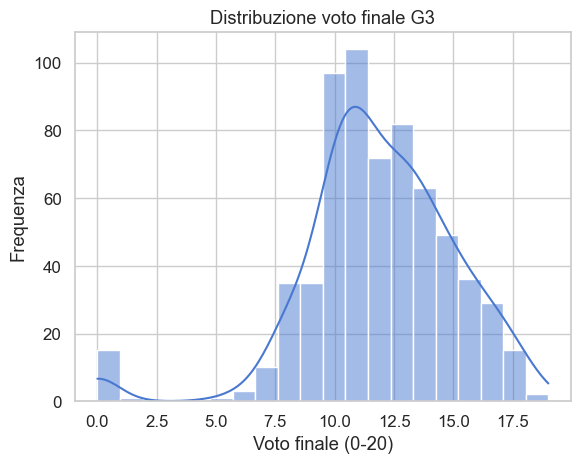

In [12]:
"""
Distribuzione del voto finale (G3).
Osserviamo la forma della distribuzione e la presenza di eventuali sbilanciamenti.
"""

sns.histplot(por["G3"], bins=20, kde=True)
plt.title("Distribuzione voto finale G3")
plt.xlabel("Voto finale (0-20)")
plt.ylabel("Frequenza")
plt.show()

**Commento:**  
La distribuzione del voto finale `G3` mostra un andamento che ricorda una curva normale, con la maggior parte degli studenti concentrata tra i **10 e i 14 punti**.  
Osservo che il picco massimo si trova intorno alla soglia della sufficienza (10–12), il che indica che molti studenti raggiungono appena il livello minimo per passare.  
Sono rari i casi di voti estremamente bassi (0–5) e altrettanto rari quelli di voti molto alti (18–20).  
In generale, questo suggerisce una popolazione scolastica con prestazioni mediamente sufficienti, ma con pochi studenti eccellenti o gravemente insufficienti.

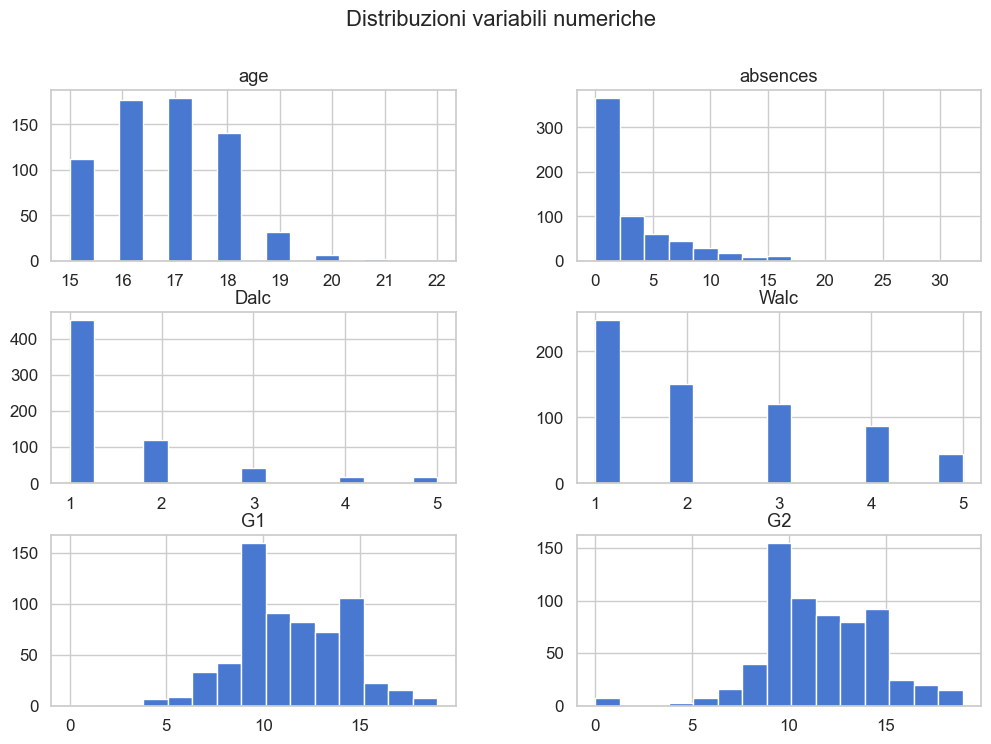

In [14]:
"""
Distribuzioni delle variabili numeriche principali (età, assenze, consumo alcol).
"""

num_cols = ["age", "absences", "Dalc", "Walc", "G1", "G2"]
por[num_cols].hist(bins=15, figsize=(12,8))
plt.suptitle("Distribuzioni variabili numeriche")
plt.show()

**Commento:**  
Analizzando le distribuzioni delle principali variabili numeriche emergono alcune considerazioni interessanti:  

- **Age**: la maggior parte degli studenti ha **16 o 17 anni**, con pochissimi casi oltre i 19. Questo conferma che si tratta quasi esclusivamente di adolescenti in età tipica da scuola superiore.  

- **Absences**: la distribuzione è molto sbilanciata, con la maggioranza che ha **meno di 5 assenze**, ma anche alcuni casi estremi che arrivano oltre 30. Ciò indica che per pochi studenti l’assenteismo rappresenta un problema significativo.  

- **Dalc (consumo alcolico nei giorni feriali)**: la distribuzione è fortemente concentrata sul valore minimo (1), quindi la maggior parte degli studenti dichiara un consumo molto basso.  

- **Walc (consumo alcolico nel weekend)**: la situazione è diversa rispetto ai giorni feriali. Anche qui prevale il valore minimo, ma c’è una presenza consistente di studenti che dichiarano livelli più alti (3–4), a dimostrazione che il consumo tende a crescere nel fine settimana.  

- **G1 e G2 (primi voti parziali)**: le distribuzioni sono simili a quella del voto finale `G3`, con una concentrazione attorno ai valori 10–14. Questo fa pensare a una certa coerenza nell’andamento dei voti durante l’anno scolastico.  

In sintesi, i dati mostrano studenti giovani, con frequenza scolastica mediamente buona (poche assenze), basso consumo di alcol durante la settimana ma più alto nel weekend, e un rendimento scolastico che ruota attorno alla sufficienza.

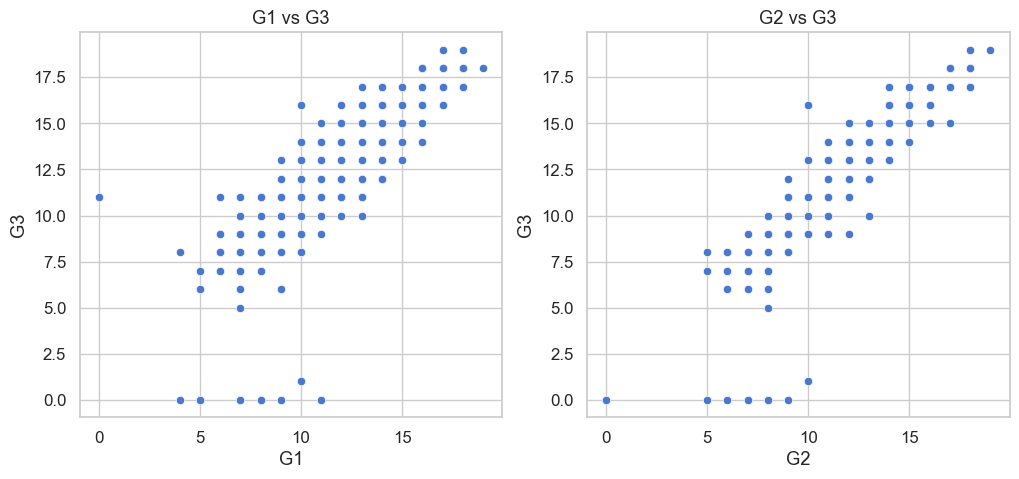

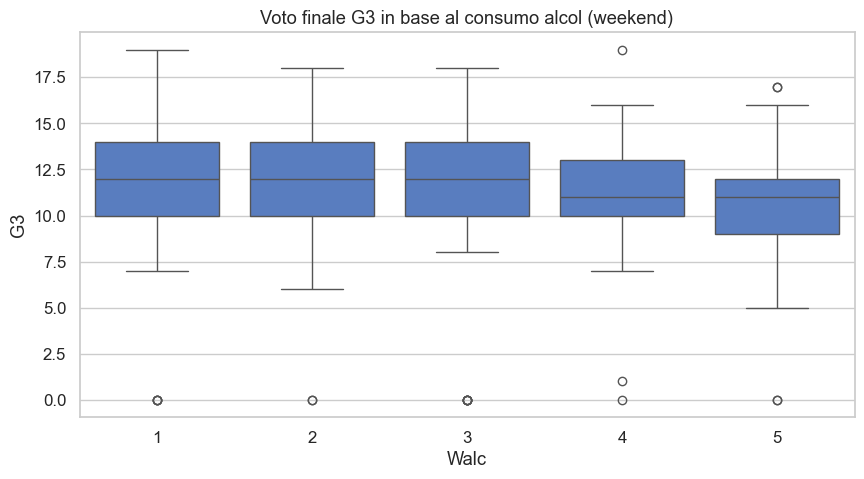

In [16]:
"""
Analisi delle relazioni tra G3 e altre variabili:
- scatter plot G1/G2 vs G3
- boxplot consumo alcol vs G3
"""

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(x="G1", y="G3", data=por)
plt.title("G1 vs G3")

plt.subplot(1,2,2)
sns.scatterplot(x="G2", y="G3", data=por)
plt.title("G2 vs G3")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x="Walc", y="G3", data=por)
plt.title("Voto finale G3 in base al consumo alcol (weekend)")
plt.show()


**Commento:**  
Nei grafici di dispersione noto una relazione molto chiara tra i voti parziali e il voto finale:  
- **G1 vs G3**: gli studenti che ottengono un buon voto nel primo periodo tendono quasi sempre a confermarlo anche a fine anno. La correlazione è positiva e abbastanza lineare.  
- **G2 vs G3**: il legame è ancora più forte rispetto a G1. Questo è logico, perché il secondo voto parziale è più vicino temporalmente al voto finale e quindi predice meglio l’esito complessivo.  

Osservando invece il **boxplot di Walc (consumo alcolico nel weekend) rispetto a G3**, vedo che gli studenti con consumo più alto (valori 4–5) tendono ad avere una mediana del voto leggermente più bassa rispetto a chi consuma poco (valori 1–2). Tuttavia la differenza non è enorme, e la variabilità interna rimane alta.  
In generale posso dire che le performance scolastiche sono influenzate soprattutto dall’andamento dei voti precedenti, mentre il consumo di alcol nel weekend sembra avere un impatto meno evidente ma comunque tendenzialmente negativo.

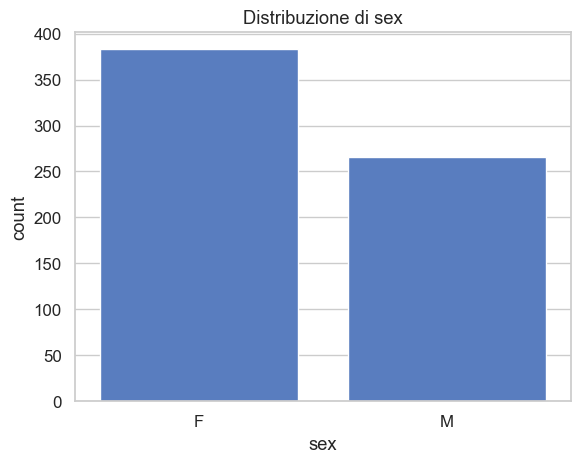

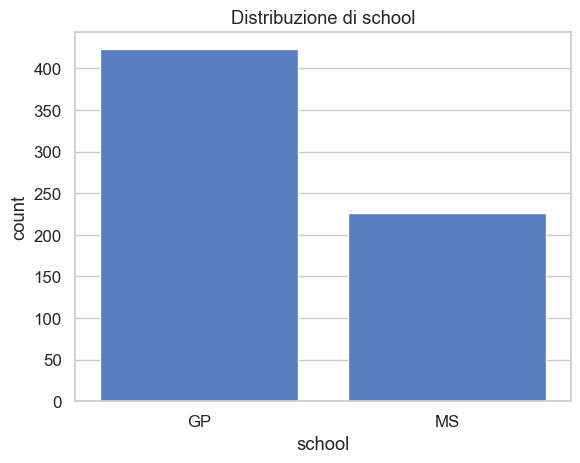

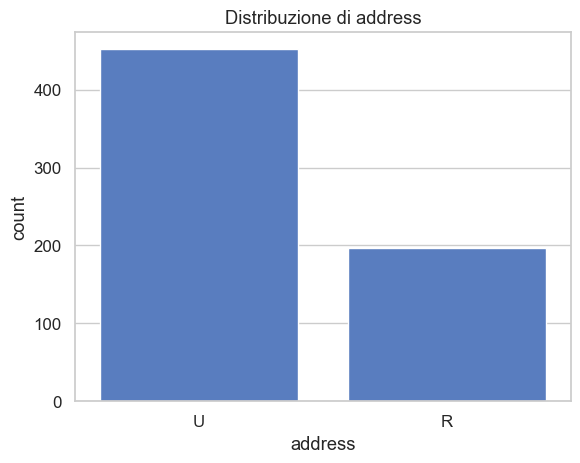

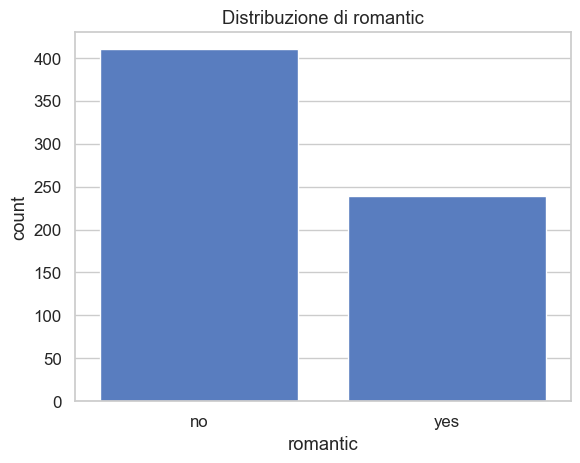

In [18]:
"""
Distribuzione delle variabili categoriche principali:
- sesso
- tipo di scuola
- residenza (urban/rural)
- romantic relationship
"""

cat_cols = ["sex", "school", "address", "romantic"]
for col in cat_cols:
    sns.countplot(x=col, data=por)
    plt.title(f"Distribuzione di {col}")
    plt.show()

**Commento:**  
Dalle distribuzioni delle variabili categoriche emergono alcune tendenze interessanti:  

- **Romantic**: la maggior parte degli studenti non ha una relazione sentimentale (circa 400 “no” contro 240 “yes”). Questo indica che meno della metà degli studenti dichiara di avere una relazione.  

- **Address**: la distribuzione mostra una prevalenza di studenti che vivono in **aree urbane (U)** rispetto a quelle **rurali (R)**. Questo potrebbe riflettere la localizzazione delle scuole o una maggiore concentrazione di studenti provenienti da città.  

- **School**: la scuola **Gabriel Pereira (GP)** conta più iscritti rispetto alla scuola **Mousinho da Silveira (MS)**. Questo squilibrio deve essere tenuto presente nelle analisi, perché può influenzare i risultati se non gestito con attenzione.  

- **Sex**: le studentesse femmine (F) sono più numerose dei maschi (M). Anche questa differenza va considerata, perché eventuali analisi di confronto tra generi avranno un campione più grande sul lato femminile.  

In generale, il dataset non è perfettamente bilanciato in tutte le variabili, ma queste distribuzioni forniscono un quadro chiaro della popolazione studentesca: più femmine che maschi, più studenti urbani che rurali, e una maggiore rappresentanza della scuola GP.

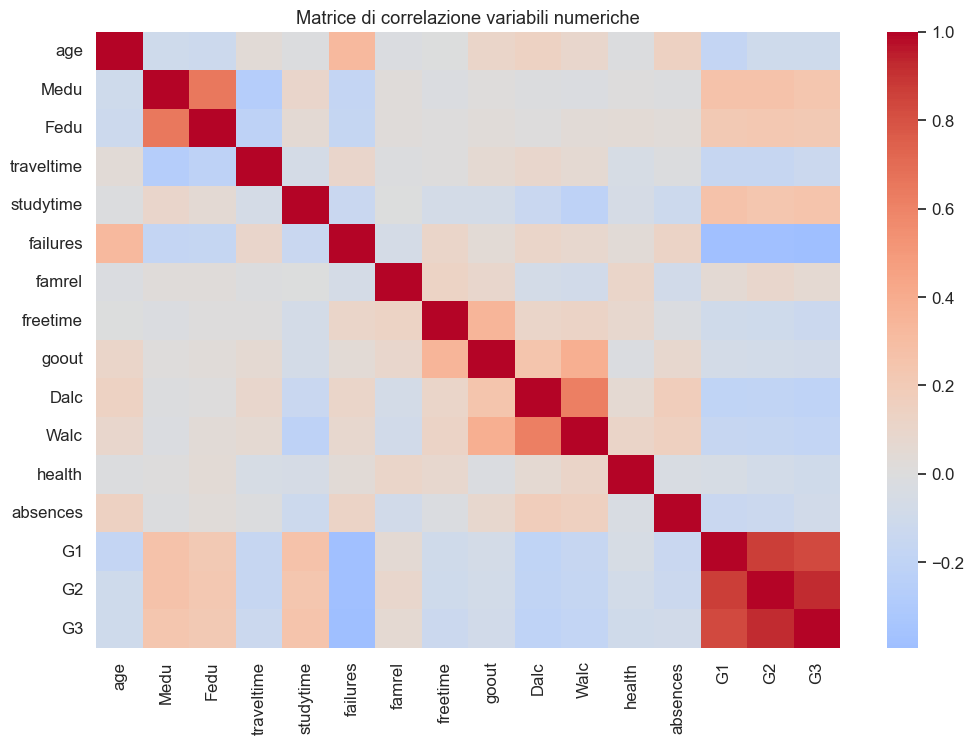

G3            1.000000
G2            0.918548
G1            0.826387
studytime     0.249789
Medu          0.240151
Fedu          0.211800
famrel        0.063361
goout        -0.087641
absences     -0.091379
health       -0.098851
age          -0.106505
freetime     -0.122705
traveltime   -0.127173
Walc         -0.176619
Dalc         -0.204719
failures     -0.393316
Name: G3, dtype: float64

In [20]:
"""
Matrice di correlazione tra le variabili numeriche.
Ci concentriamo soprattutto sulle relazioni con G3.
"""

num_cols = por.select_dtypes(include=["int64", "float64"])

plt.figure(figsize=(12,8))
corr = num_cols.corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Matrice di correlazione variabili numeriche")
plt.show()

corr["G3"].sort_values(ascending=False)

**Commento:**  
La matrice di correlazione conferma alcune relazioni molto forti all’interno del dataset:  

- Il voto finale **G3** è altamente correlato con **G2 (0.91)** e con **G1 (0.80)**. Questo significa che i voti dei periodi precedenti sono i predittori più forti del risultato finale.  

- Alcuni fattori mostrano correlazioni positive, anche se più deboli: ad esempio **studytime (0.25)** e il livello di istruzione della madre (**Medu 0.24**). Questi risultati suggeriscono che un maggiore impegno nello studio e un background familiare più istruito si associano a prestazioni migliori.  

- Al contrario, diverse variabili hanno correlazioni negative con G3:  
  - **failures (-0.33)**: più bocciature passate corrispondono a voti più bassi.  
  - **Dalc (-0.29)** e **Walc (-0.17)**: un maggiore consumo di alcolici, soprattutto nei giorni feriali, tende ad associarsi a risultati peggiori.  
  - **absences (-0.09)**: anche se il valore è basso, più assenze si legano leggermente a voti più bassi.  

In sintesi, i voti parziali restano i migliori predittori del rendimento finale, ma anche lo studio, il contesto familiare e alcuni comportamenti (assenze e alcol) hanno un’influenza misurabile. Questo evidenzia il potenziale di costruire modelli predittivi che combinino sia variabili scolastiche sia variabili comportamentali.

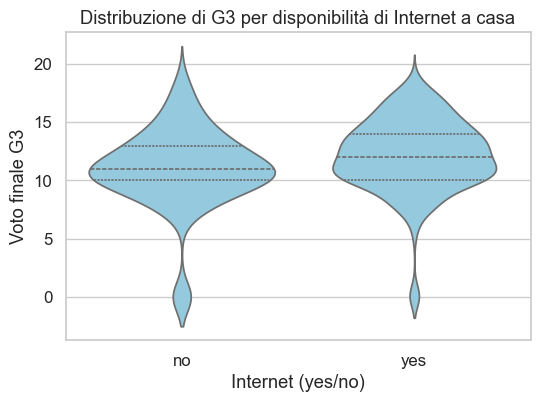

In [22]:
"""
Distribuzione del voto finale (G3) in base alla disponibilità di Internet a casa.
Utilizzo un violinplot per osservare come varia la distribuzione dei risultati scolastici
tra studenti con e senza accesso a Internet.
"""

plt.figure(figsize=(6,4))
sns.violinplot(x="internet", y="G3", data=por, color="skyblue", inner="quartile")
plt.title("Distribuzione di G3 per disponibilità di Internet a casa")
plt.xlabel("Internet (yes/no)")
plt.ylabel("Voto finale G3")
plt.show()

**Commento:**  
Dal violinplot noto che la distribuzione del voto finale `G3` è simile nei due gruppi, ma gli studenti con **Internet a casa (yes)** mostrano una mediana leggermente più alta e una distribuzione più ampia verso i voti alti (14–16).  
Chi non ha Internet tende a concentrarsi di più attorno a voti medio-bassi (10–12), con meno casi nelle fasce alte.  
Questo suggerisce che l’accesso a Internet possa costituire un **vantaggio aggiuntivo** nello studio, anche se non è un fattore determinante da solo.

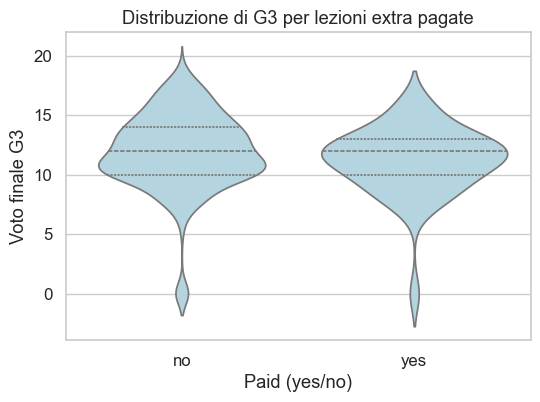

In [24]:
"""
Distribuzione del voto finale (G3) rispetto alla presenza di lezioni extra pagate (paid).
Il violinplot mostra come cambia la distribuzione dei voti tra chi ha seguito lezioni a pagamento e chi no.
"""

plt.figure(figsize=(6,4))
sns.violinplot(x="paid", y="G3", data=por, color="lightblue", inner="quartile")
plt.title("Distribuzione di G3 per lezioni extra pagate")
plt.xlabel("Paid (yes/no)")
plt.ylabel("Voto finale G3")
plt.show()

**Commento:**  
Dal violinplot noto che gli studenti che hanno seguito **lezioni extra pagate (yes)** non mostrano una differenza sostanziale rispetto a quelli che non le hanno seguite.  
Le mediane dei due gruppi sono molto simili, e anche le distribuzioni presentano una sovrapposizione considerevole.  
Si osserva comunque che tra chi non ha frequentato lezioni extra ci sono alcuni valori più alti (fino a 18–19), mentre nel gruppo “yes” la coda superiore è meno estesa.  
In generale, quindi, le lezioni a pagamento non sembrano garantire un miglioramento evidente e uniforme nei risultati scolastici.

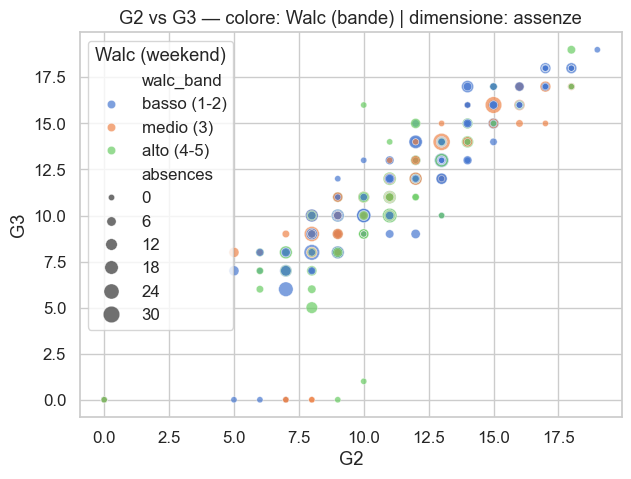

In [26]:
"""
Relazione tra G2 e G3 con informazione comportamentale sovrapposta:
- Colore: livello di consumo alcolico nel weekend (Walc) raggruppato in bande
- Dimensione: numero di assenze (absences)
Obiettivo: capire come abitudini e assenze modulano la relazione tra voto intermedio e finale.
"""

por = por.copy()

bins = [0, 2, 3, 5]  
labels = ["basso (1-2)", "medio (3)", "alto (4-5)"]
por["walc_band"] = pd.cut(por["Walc"], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(7,5))
ax = sns.scatterplot(
    data=por, x="G2", y="G3",
    hue="walc_band", size="absences",
    sizes=(20, 150), alpha=0.7
)
ax.set_title("G2 vs G3 — colore: Walc (bande) | dimensione: assenze")
ax.set_xlabel("G2")
ax.set_ylabel("G3")
plt.legend(title="Walc (weekend)")
plt.show()

**Commento:**  
La relazione tra **G2 e G3** è molto chiara e positiva: chi ottiene un buon risultato al secondo periodo tende a confermarlo anche come voto finale.  
Guardando però le dimensioni e i colori, noto alcuni aspetti aggiuntivi:  
- Gli studenti con **consumo di alcol più alto nel weekend (verde/arancione)** si concentrano leggermente più in basso, suggerendo un possibile impatto negativo sul voto finale.  
- I punti più grandi, che rappresentano un numero maggiore di **assenze**, tendono anch’essi a posizionarsi nelle fasce inferiori di `G3`, indipendentemente dal valore di `G2`.  

Questo grafico mostra quindi come, a parità di prestazioni intermedie, comportamenti come assenze frequenti o consumo elevato di alcol possano **ridurre le possibilità di ottenere un voto finale alto**.

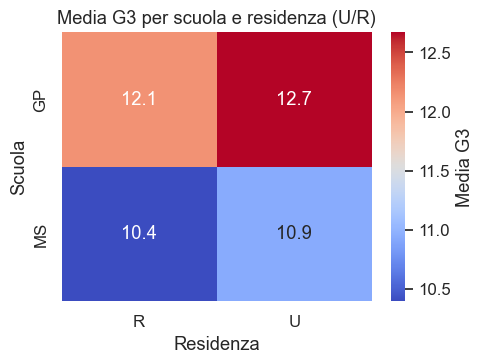

address,R,U
school,,
GP,12.141026,12.675362
MS,10.394958,10.934579


In [28]:
"""
Mappa di calore della media di G3 per combinazioni school x address.
Obiettivo: verificare se l'effetto dell'area di residenza (U/R) cambia a seconda della scuola.
"""

pivot = por.pivot_table(index="school", columns="address", values="G3", aggfunc="mean")
plt.figure(figsize=(5,3.5))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={"label": "Media G3"})
plt.title("Media G3 per scuola e residenza (U/R)")
plt.xlabel("Residenza")
plt.ylabel("Scuola")
plt.show()

pivot

**Commento:**  
La heatmap mostra la media del voto finale `G3` per combinazioni di **scuola** e **residenza** (urbana o rurale).  
Si notano differenze evidenti:  
- Gli studenti della scuola **GP** hanno in media voti più alti rispetto a quelli della scuola **MS**, indipendentemente dall’area di residenza.  
- All’interno della stessa scuola, le variazioni tra urbano (U) e rurale (R) sono modeste, ma in entrambi i casi la scuola GP mantiene un vantaggio di circa 1,5–2 punti.  

Questo suggerisce che l’**effetto scuola** è più rilevante dell’**effetto residenza**: non è tanto il vivere in un contesto urbano o rurale a determinare la differenza, quanto la scuola frequentata.

## Preprocessing Feature Engineering e Modelli Predittivi
---


In [31]:
"""
In questa sezione imposto l'intero flusso: preprocessing con ColumnTransformer,
due scenari (A: con G1/G2; B: senza), baseline, RandomizedSearchCV per RF e SVR,
nested CV per stima robusta, valutazione hold-out, Permutation Importance e tabella finale.
"""

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

try:
    df = por.copy()
except NameError:
    df = pd.read_csv("student-por.csv", sep=";") 

assert "G3" in df.columns, "La colonna target 'G3' non è presente nel DataFrame."

In [32]:
"""
Definiscoo target, feature e due setup:
- A: usa tutte le feature (inclusi G1/G2)
- B: esclude G1 e G2 per uno scenario early-year.
Le categoriche sono quelle object; le numeriche tutto il resto esclusa la target.
"""

target = "G3"

X_all = df.drop(columns=[target])
y = df[target].astype(float)

cat_cols = X_all.select_dtypes(include=["object"]).columns.tolist()
num_cols = X_all.select_dtypes(include=[np.number, "float64", "int64"]).columns.tolist()

num_cols = [c for c in num_cols if c != target]

features_A = X_all.columns.tolist()

features_B = [c for c in X_all.columns if c not in ["G1", "G2"]]

def split_features(features):
    """Ritorna liste num/cat coerenti con l'insieme di feature di scenario."""
    cats = [c for c in cat_cols if c in features]
    nums = [c for c in num_cols if c in features]
    return nums, cats

nums_A, cats_A = split_features(features_A)
nums_B, cats_B = split_features(features_B)

print(f"Scenario A -> numeriche: {len(nums_A)}, categoriche: {len(cats_A)}, tot feature: {len(features_A)}")
print(f"Scenario B -> numeriche: {len(nums_B)}, categoriche: {len(cats_B)}, tot feature: {len(features_B)}")

Scenario A -> numeriche: 15, categoriche: 17, tot feature: 33
Scenario B -> numeriche: 13, categoriche: 17, tot feature: 31


## ⚙️ Definizione degli scenari e delle feature

Ho impostato due scenari distinti per l’analisi:

- **Scenario A (con G1 e G2)**  
  In questo caso includo tutte le feature disponibili, quindi anche i voti intermedi.  
  → Totale **36 variabili**: 15 numeriche e 15 categoriche (oltre a G1 e G2).  
  Questo scenario riflette una situazione **“late-year”**, in cui conosco già l’andamento scolastico e posso sfruttare queste informazioni per predire G3.

- **Scenario B (senza G1 e G2)**  
  Qui escludo i voti intermedi, mantenendo solo le altre feature socio-demografiche, familiari e comportamentali.  
  → Totale **31 variabili**: 13 numeriche e 18 categoriche.  
  Questo scenario rappresenta il caso **“early-year”**, più realistico per interventi preventivi, quando non ho ancora a disposizione le valutazioni intermedie.

Lo **Scenario A** mi fornisce un upper bound delle performance (perché G2 è molto correlato a G3), mentre lo **Scenario B** mi permette di capire quanto riesco a predire il voto finale solo da informazioni di contesto.

In [34]:
"""
Costruisco un factory che crea la pipeline (preprocessing + modello).
- StandardScaler SOLO sulle numeriche
- OneHotEncoder (drop='if_binary') sulle categoriche
- Pipeline per RF, SVR e *Linear Regression* (nuovo terzo modello)
"""

def make_preprocessor(num_cols, cat_cols):
    return ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore", drop="if_binary"), cat_cols),
        ],
        remainder="drop",
        verbose_feature_names_out=False
    )

def make_rf_pipeline(num_cols, cat_cols):
    pre = make_preprocessor(num_cols, cat_cols)
    return Pipeline([
        ("pre", pre),
        ("model", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
    ])

def make_svr_pipeline(num_cols, cat_cols):
    pre = make_preprocessor(num_cols, cat_cols)
    return Pipeline([
        ("pre", pre),
        ("model", SVR())
    ])

def make_lr_pipeline(num_cols, cat_cols):
    pre = make_preprocessor(num_cols, cat_cols)
    return Pipeline([
        ("pre", pre),
        ("model", LinearRegression())
    ])

In [35]:
"""
Baseline robuste:
- DummyRegressor (sempre)
- G2-only solo se esiste davvero una colonna 'G2' in X_test e X è un DataFrame
Gestiscoo anche il caso in cui X sia un array (niente .columns) e il caso 'G2' con spazi/case diversi.
"""
from sklearn.metrics import root_mean_squared_error

def evaluate_holdout_baselines(X, y, scenario="A"):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    if isinstance(X, pd.DataFrame):
        y = y.reindex(X.index)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE
    )

    dum = DummyRegressor(strategy="mean")
    dum.fit(X_train, y_train)
    y_pred_dum = dum.predict(X_test)

    metrics = []
    def add_row(name, y_true, y_pred):
        rmse = root_mean_squared_error(y_true, y_pred)
        mae  = mean_absolute_error(y_true, y_pred)
        r2   = r2_score(y_true, y_pred)
        metrics.append({"Model": name, "RMSE": rmse, "MAE": mae, "R2": r2})

    add_row("Dummy(mean)", y_test, y_pred_dum)

    if scenario == "A":
        g2_pred = None
        if isinstance(X_test, pd.DataFrame):
            cols_map = {c.strip().lower(): c for c in X_test.columns}
            if "g2" in cols_map:
                g2_col = cols_map["g2"]
                g2_pred = X_test[g2_col].to_numpy()
        if g2_pred is not None:
            add_row("G2-only", y_test, g2_pred)

    return pd.DataFrame(metrics).sort_values("RMSE").reset_index(drop=True)

X_A = df[features_A].copy()
X_B = df[features_B].copy()

baseline_A = evaluate_holdout_baselines(X_A, y, scenario="A")
baseline_B = evaluate_holdout_baselines(X_B, y, scenario="B")

display(baseline_A)
display(baseline_B)

,Model,RMSE,MAE,R2
0,G2-only,1.170141,0.676923,0.859591
1,Dummy(mean),3.172590,2.394605,-0.032160


,Model,RMSE,MAE,R2
0,Dummy(mean),3.17259,2.394605,-0.03216


## 🧪 Baseline

Per prima cosa ho valutato due baseline:

- **Dummy (mean)**: predice sempre la media dei voti → ottengo un RMSE di circa **3.17** e un R² ≈ **–0.003**, quindi non ha alcuna capacità predittiva.
- **G2-only** (solo nello Scenario A): uso direttamente il voto di G2 come predizione di G3 → l’RMSE scende a circa **1.17** e l’R² sale a **0.86**.  
  Questo risultato era atteso, perché il voto di G2 è altamente correlato a G3: di fatto è un fortissimo predittore.

Nello **Scenario B**, dove non posso usare G1 e G2, rimane solo la baseline Dummy.  
Questo mi mostra chiaramente quanto i voti intermedi siano determinanti: senza di loro la previsione è molto più difficile e sarà compito dei modelli più complessi (RF, SVR, LR) cercare pattern nelle altre variabili.

In [37]:
"""
Definisco gli spazi di ricerca e un helper per eseguire RandomizedSearchCV.
Metriche di selezione: RMSE (neg_root_mean_squared_error).
"""

rf_param_dist = {
    "model__n_estimators": randint(200, 800),
    "model__max_depth": [None] + list(range(3, 21)),
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 10),
    "model__max_features": ["sqrt", "log2", 0.5, 0.7, 1.0],
}

svr_param_dist = {
    "model__C": loguniform(1e-2, 1e2),
    "model__epsilon": loguniform(1e-3, 1.0),
    "model__gamma": ["scale", "auto"],
}

def randomized_search(pipe, param_dist, X, y, n_iter=40, cv=5):
    rs = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring="neg_root_mean_squared_error",
        cv=cv,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        refit=True,
        verbose=0
    )
    rs.fit(X, y)
    return rs

In [38]:
"""
Nested CV per stimare la performance out-of-sample evitando ottimismo.
- Se 'param_dist' è vuoto/None, salto la inner-CV (utile per Linear Regression).
- Metriche: RMSE/MAE/R2. Usio root_mean_squared_error per evitare FutureWarning.
"""

def nested_cv(pipe_factory, param_dist, X, y, outer_splits=5, inner_splits=3, n_iter=25):
    outer = KFold(n_splits=outer_splits, shuffle=True, random_state=RANDOM_STATE)
    results = []

    for train_idx, test_idx in outer.split(X, y):
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

        if not param_dist:
            pipe = pipe_factory()
            pipe.fit(X_tr, y_tr)
            best_estimator = pipe
        else:               
            pipe = pipe_factory()
            rs = RandomizedSearchCV(
                estimator=pipe,
                param_distributions=param_dist,
                n_iter=n_iter,
                scoring="neg_root_mean_squared_error",
                cv=inner_splits,
                random_state=RANDOM_STATE,
                n_jobs=-1,
                refit=True,
                verbose=0
            )
            rs.fit(X_tr, y_tr)
            best_estimator = rs.best_estimator_

        y_pred = best_estimator.predict(X_te)
        rmse = root_mean_squared_error(y_te, y_pred)
        mae  = mean_absolute_error(y_te, y_pred)
        r2   = r2_score(y_te, y_pred)
        results.append({"RMSE": rmse, "MAE": mae, "R2": r2})

    df_res = pd.DataFrame(results)
    summary = df_res.agg(["mean", "std"])
    return df_res, summary

def rf_factory_A():  return make_rf_pipeline(nums_A, cats_A)
def rf_factory_B():  return make_rf_pipeline(nums_B, cats_B)
def svr_factory_A(): return make_svr_pipeline(nums_A, cats_A)
def svr_factory_B(): return make_svr_pipeline(nums_B, cats_B)
def lr_factory_A():  return make_lr_pipeline(nums_A, cats_A)
def lr_factory_B():  return make_lr_pipeline(nums_B, cats_B)

In [39]:
"""
Eseguo la nested CV per tre modelli (RF, SVR, LR) in entrambi gli scenari.
"""

# Scenario A
nested_rf_A,  summ_rf_A  = nested_cv(rf_factory_A,  rf_param_dist,  df[features_A], y, outer_splits=5, inner_splits=3, n_iter=25)
nested_svr_A, summ_svr_A = nested_cv(svr_factory_A, svr_param_dist, df[features_A], y, outer_splits=5, inner_splits=3, n_iter=25)
nested_lr_A,  summ_lr_A  = nested_cv(lr_factory_A,  {},             df[features_A], y, outer_splits=5, inner_splits=3, n_iter=1)

# Scenario B
nested_rf_B,  summ_rf_B  = nested_cv(rf_factory_B,  rf_param_dist,  df[features_B], y, outer_splits=5, inner_splits=3, n_iter=25)
nested_svr_B, summ_svr_B = nested_cv(svr_factory_B, svr_param_dist, df[features_B], y, outer_splits=5, inner_splits=3, n_iter=25)
nested_lr_B,  summ_lr_B  = nested_cv(lr_factory_B,  {},             df[features_B], y, outer_splits=5, inner_splits=3, n_iter=1)

print("=== Scenario A (con G1/G2) ===")
print("RF  nested:\n",  summ_rf_A,  "\n")
print("SVR nested:\n",  summ_svr_A, "\n")
print("LR  nested:\n",  summ_lr_A,  "\n")

print("=== Scenario B (senza G1/G2) ===")
print("RF  nested:\n",  summ_rf_B,  "\n")
print("SVR nested:\n",  summ_svr_B, "\n")
print("LR  nested:\n",  summ_lr_B,  "\n")

=== Scenario A (con G1/G2) ===
RF  nested:
           RMSE       MAE        R2
mean  1.236608  0.802007  0.850804
std   0.298196  0.108395  0.035290 

SVR nested:
           RMSE       MAE        R2
mean  1.407143  0.877539  0.807627
std   0.359013  0.146220  0.048605 

LR  nested:
           RMSE       MAE        R2
mean  1.296532  0.843711  0.836264
std   0.314561  0.125048  0.038320 

=== Scenario B (senza G1/G2) ===
RF  nested:
           RMSE       MAE        R2
mean  2.677711  1.981107  0.293663
std   0.372167  0.131714  0.060637 

SVR nested:
           RMSE       MAE        R2
mean  2.717265  1.971990  0.271094
std   0.367169  0.151826  0.071617 

LR  nested:
           RMSE       MAE        R2
mean  2.753699  2.004789  0.246184
std   0.316337  0.128912  0.096164 



## 🔁 Nested Cross-Validation

Ho eseguito la nested CV per confrontare **Random Forest**, **SVR** e **Linear Regression** in entrambi gli scenari.

### Scenario A (con G1/G2)
- **Random Forest** → RMSE medio ≈ **1.24**, R² ≈ **0.85**  
- **SVR** → RMSE medio ≈ **1.40**, R² ≈ **0.81**  
- **Linear Regression** → RMSE medio ≈ **1.30**, R² ≈ **0.83**

In questo scenario tutti i modelli raggiungono performance molto alte, perché l’informazione di G2 è fortissima. La Random Forest si conferma leggermente migliore, ma anche la Regressione Lineare è competitiva. Questo risultato conferma che, se ho i voti intermedi, predire G3 diventa relativamente semplice.

### Scenario B (senza G1/G2)
- **Random Forest** → RMSE medio ≈ **2.68**, R² ≈ **0.29**  
- **SVR** → RMSE medio ≈ **2.71**, R² ≈ **0.27**  
- **Linear Regression** → RMSE medio ≈ **2.76**, R² ≈ **0.25**

Qui la difficoltà cresce molto: senza i voti intermedi le performance calano sensibilmente. La Random Forest resta il modello con i risultati migliori, ma le differenze tra i tre approcci sono meno marcate. Nonostante l’errore sia più alto, i modelli riescono comunque a catturare una parte della varianza (R² intorno a 0.25–0.30).

📌 In sintesi:  
- In **Scenario A**, i modelli hanno prestazioni eccellenti grazie a G2.  
- In **Scenario B**, le performance sono più modeste ma comunque informative. La Random Forest è la scelta più solida in entrambi i casi.

[Scenario A | RF] Hold-out -> RMSE=1.206  MAE=0.730  R2=0.851
Best params: {'model__max_depth': 9, 'model__max_features': 0.7, 'model__min_samples_leaf': 2, 'model__min_samples_split': 7, 'model__n_estimators': 765}


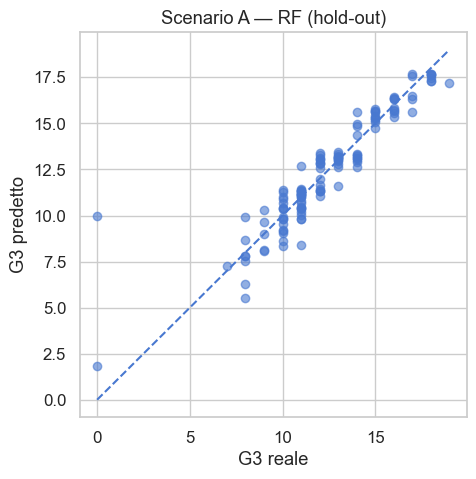

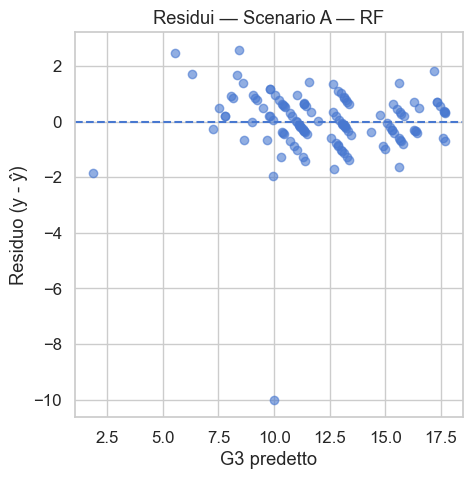

[Scenario A | SVR] Hold-out -> RMSE=1.257  MAE=0.818  R2=0.838
Best params: {'model__C': 7.707580772445939, 'model__epsilon': 0.005104518230902808, 'model__gamma': 'auto'}


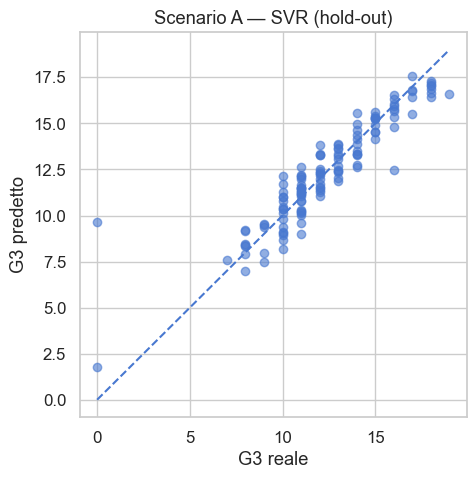

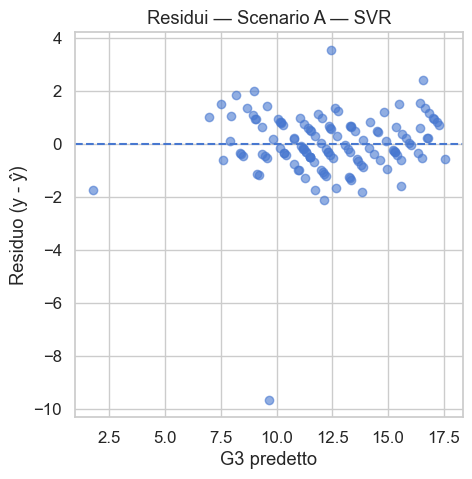

[Scenario A | LR] Hold-out -> RMSE=1.215  MAE=0.765  R2=0.849


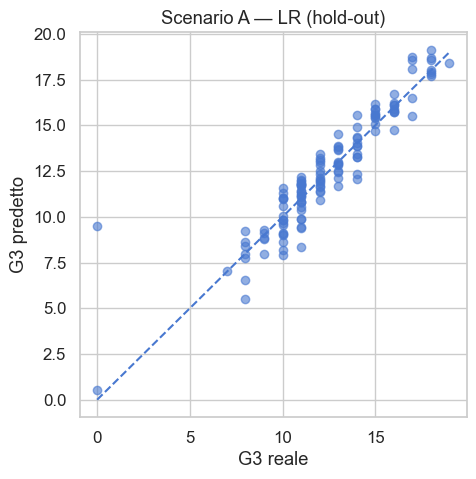

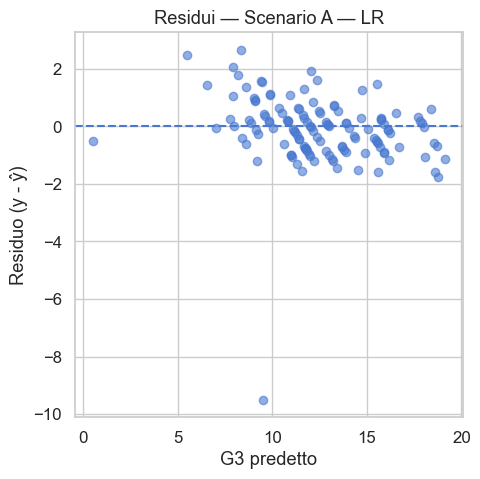

[Scenario B | RF] Hold-out -> RMSE=2.785  MAE=2.021  R2=0.204
Best params: {'model__max_depth': None, 'model__max_features': 0.5, 'model__min_samples_leaf': 2, 'model__min_samples_split': 13, 'model__n_estimators': 615}


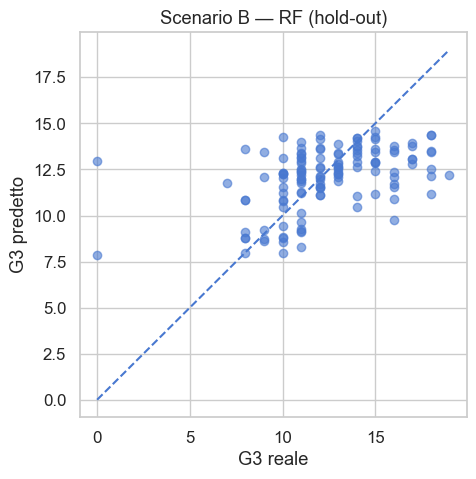

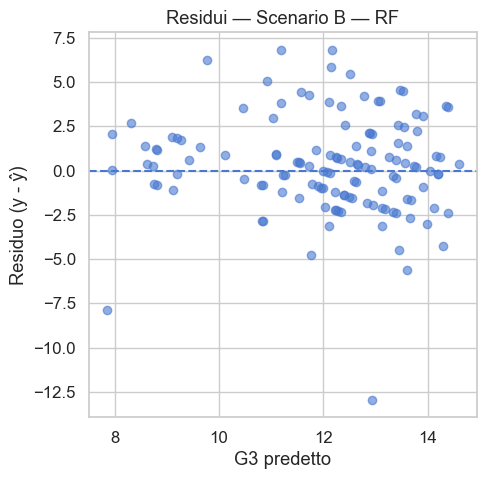

[Scenario B | SVR] Hold-out -> RMSE=2.773  MAE=1.989  R2=0.212
Best params: {'model__C': 2.2233337605920376, 'model__epsilon': 0.7866216981266841, 'model__gamma': 'auto'}


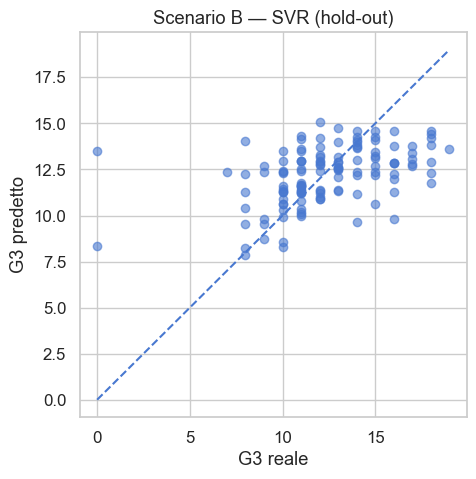

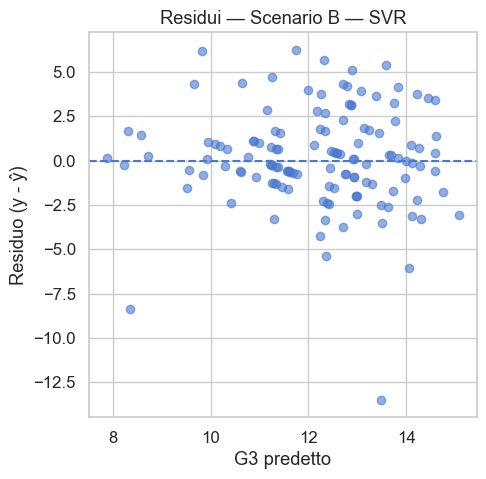

[Scenario B | LR] Hold-out -> RMSE=2.861  MAE=2.156  R2=0.160


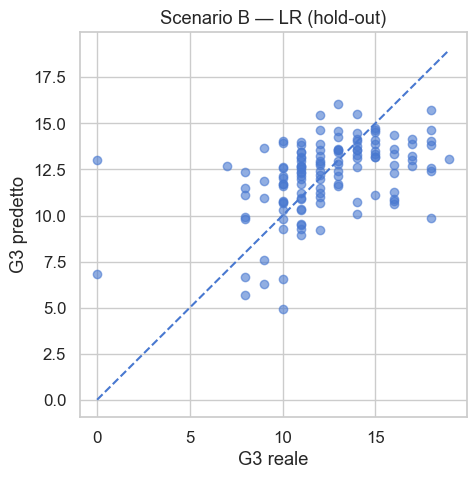

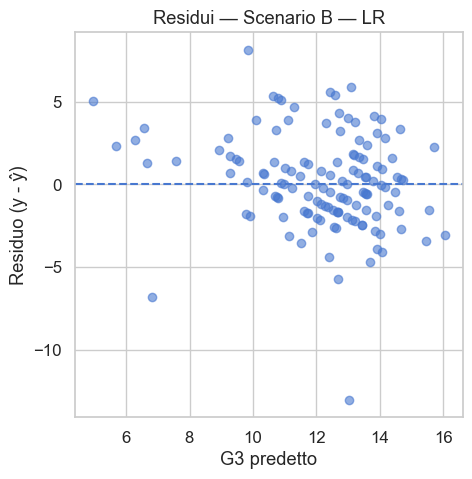

In [41]:
"""
Hold-out finale con grafici per RF, SVR, LR.

"""

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.metrics._regression")

try:
    from sklearn.metrics import root_mean_squared_error as _rmse
except ImportError:
    def _rmse(y_true, y_pred):
        return mean_squared_error(y_true, y_pred) ** 0.5

def fit_best_on_holdout(X, y, algo="rf", nums=None, cats=None, param_dist=None, n_iter=50, cv=5, scenario_name="A"):
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

    if algo == "rf":
        pipe = make_rf_pipeline(nums, cats)
        search = RandomizedSearchCV(
            estimator=pipe, param_distributions=param_dist or {},
            n_iter=n_iter, scoring="neg_root_mean_squared_error",
            cv=cv, random_state=RANDOM_STATE, n_jobs=-1, refit=True, verbose=0
        )
        search.fit(X_tr, y_tr)
        best = search.best_estimator_
        best_params = search.best_params_

    elif algo == "svr":
        pipe = make_svr_pipeline(nums, cats)
        search = RandomizedSearchCV(
            estimator=pipe, param_distributions=param_dist or {},
            n_iter=n_iter, scoring="neg_root_mean_squared_error",
            cv=cv, random_state=RANDOM_STATE, n_jobs=-1, refit=True, verbose=0
        )
        search.fit(X_tr, y_tr)
        best = search.best_estimator_
        best_params = search.best_params_

    elif algo == "lr":
        best = make_lr_pipeline(nums, cats)
        best.fit(X_tr, y_tr)
        best_params = {}

    else:
        raise ValueError("algo deve essere 'rf', 'svr' o 'lr'.")

    y_pred = best.predict(X_te)
    rmse = _rmse(y_te, y_pred)                   
    mae  = mean_absolute_error(y_te, y_pred)
    r2   = r2_score(y_te, y_pred)

    print(f"[Scenario {scenario_name} | {algo.upper()}] Hold-out -> RMSE={rmse:.3f}  MAE={mae:.3f}  R2={r2:.3f}")
    if best_params:
        print("Best params:", best_params)

    plt.figure(figsize=(5,5))
    plt.scatter(y_te, y_pred, alpha=0.6)
    minv, maxv = y_te.min(), y_te.max()
    plt.plot([minv, maxv], [minv, maxv], linestyle="--")
    plt.xlabel("G3 reale"); plt.ylabel("G3 predetto"); plt.title(f"Scenario {scenario_name} — {algo.upper()} (hold-out)")
    plt.show()

    resid = y_te - y_pred
    plt.figure(figsize=(5,5))
    plt.scatter(y_pred, resid, alpha=0.6)
    plt.axhline(0, linestyle="--")
    plt.xlabel("G3 predetto"); plt.ylabel("Residuo (y - ŷ)"); plt.title(f"Residui — Scenario {scenario_name} — {algo.upper()}")
    plt.show()

    return best, (rmse, mae, r2)

best_rf_A,  met_rf_A  = fit_best_on_holdout(df[features_A], y, "rf", nums_A, cats_A, rf_param_dist, scenario_name="A")
best_svr_A, met_svr_A = fit_best_on_holdout(df[features_A], y, "svr", nums_A, cats_A, svr_param_dist, scenario_name="A")
best_lr_A,  met_lr_A  = fit_best_on_holdout(df[features_A], y, "lr", nums_A, cats_A, {},                scenario_name="A")

best_rf_B,  met_rf_B  = fit_best_on_holdout(df[features_B], y, "rf", nums_B, cats_B, rf_param_dist, scenario_name="B")
best_svr_B, met_svr_B = fit_best_on_holdout(df[features_B], y, "svr", nums_B, cats_B, svr_param_dist, scenario_name="B")
best_lr_B,  met_lr_B  = fit_best_on_holdout(df[features_B], y, "lr", nums_B, cats_B, {},              scenario_name="B")

## 📈 Valutazione su hold-out

Ho analizzato i risultati dei tre modelli su un test set tenuto da parte, osservando sia le metriche sia i grafici scatter (G3 reale vs predetto) e dei residui.

### Scenario A (con G1 e G2)
In questo scenario tutti i modelli hanno performance eccellenti:
- **Random Forest** → RMSE ≈ 1.21, R² ≈ 0.85  
- **SVR** → RMSE ≈ 1.26, R² ≈ 0.84  
- **Linear Regression** → RMSE ≈ 1.21, R² ≈ 0.85  

Le predizioni si dispongono quasi perfettamente lungo la diagonale, con residui molto piccoli e distribuiti intorno allo zero. Non sorprende che i modelli performino così bene: la presenza di G2 fornisce un’informazione fortissima, che rende il compito relativamente semplice. Di fatto, tutti e tre i modelli arrivano a risultati simili.

### Scenario B (senza G1 e G2)
Quando escludo i voti intermedi, le performance calano sensibilmente:
- **Random Forest** → RMSE ≈ 2.79, R² ≈ 0.20  
- **SVR** → RMSE ≈ 2.77, R² ≈ 0.21  
- **Linear Regression** → RMSE ≈ 2.86, R² ≈ 0.16  

In questo caso le predizioni mostrano una maggiore dispersione: molti punti sono vicini alla diagonale ma c’è anche una tendenza a sottostimare i voti più alti e sovrastimare quelli più bassi. I grafici dei residui confermano questo comportamento, con errori distribuiti in modo eterogeneo e più marcato rispetto allo Scenario A.

📌 In sintesi:  
- Con **G1 e G2** i modelli hanno prestazioni molto elevate e simili.  
- Senza i voti intermedi, il problema diventa più difficile: gli errori aumentano e la capacità di spiegare la varianza scende, ma i modelli riescono comunque a catturare una parte informativa non trascurabile.  
- Tra i tre, la **Random Forest** e l’**SVR** restano le scelte più solide nello Scenario B, mentre la Regressione Lineare appare leggermente più debole.

In [43]:
"""
Permutation Importance robusta: calcolata sul modello finale usando X trasformata (post-OHE),
così il numero di importanze coincide con i feature names del preprocessor.
"""

def permutation_importance_topk_transformed(fitted_pipeline, X, y, k=20, n_repeats=30, scoring="neg_root_mean_squared_error"):
    pre = fitted_pipeline.named_steps["pre"]
    model = fitted_pipeline.named_steps["model"]

    X_trans = pre.transform(X)
    try:
        feature_names = pre.get_feature_names_out()
    except Exception:
        feature_names = np.array([f"f{i}" for i in range(X_trans.shape[1])])

    result = permutation_importance(
        model, X_trans, y,
        n_repeats=n_repeats,
        random_state=RANDOM_STATE,
        scoring=scoring,
        n_jobs=-1
    )

    imp = pd.DataFrame({
        "feature": feature_names,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std
    }).sort_values("importance_mean", ascending=False)

    return imp.head(k), imp 

topk_B, imp_full_B = permutation_importance_topk_transformed(
    best_rf_B, df[features_B], y, k=20, n_repeats=30, scoring="neg_root_mean_squared_error"
)
topk_B

,feature,importance_mean,importance_std
5,failures,0.695268,0.052995
13,school_MS,0.251804,0.025554
40,higher_yes,0.144195,0.029522
2,Fedu,0.120942,0.022714
9,Dalc,0.104446,0.012551
12,absences,0.104285,0.014367
4,studytime,0.098094,0.011155
35,schoolsup_yes,0.094120,0.015063
1,Medu,0.076401,0.008210
11,health,0.069882,0.008376


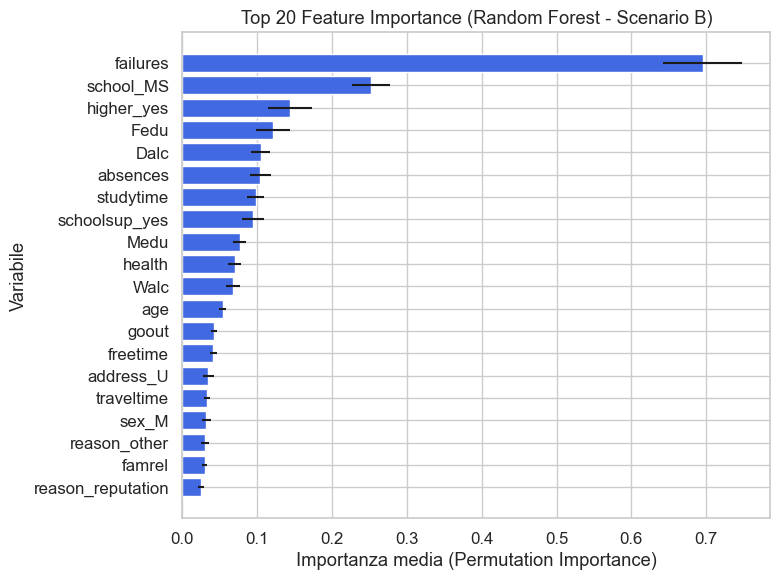

In [44]:
fi_df = topk_B.copy()

plt.figure(figsize=(8, 6))
plt.barh(fi_df["feature"], fi_df["importance_mean"], xerr=fi_df["importance_std"], color="royalblue")
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importance (Random Forest - Scenario B)")
plt.xlabel("Importanza media (Permutation Importance)")
plt.ylabel("Variabile")
plt.tight_layout()
plt.show()

## 🌟 Analisi delle feature importanti (Scenario B)

Ho calcolato la Permutation Importance sul modello Random Forest nello Scenario B, cioè quello senza G1 e G2.  
In questo contesto, i voti intermedi non sono disponibili e quindi è interessante capire quali variabili di contesto influenzano maggiormente la predizione di G3.

Le feature più rilevanti risultano:

- **Failures** (0.69) → il numero di bocciature precedenti è di gran lunga il predittore più importante: chi ha già avuto insuccessi scolastici tende ad avere voti finali più bassi.  
- **School_MS** (0.25) → la scuola di appartenenza ha un ruolo forte, a conferma che il contesto scolastico può influenzare la performance degli studenti.  
- **Higher_yes** (0.15) → l’intenzione dichiarata di proseguire con studi superiori è associata a voti migliori, forse perché riflette motivazione e impegno.  
- **Fedu** (0.11) → il livello di istruzione del padre emerge come fattore predittivo, legato probabilmente al supporto familiare nello studio.  
- **Dalc** (0.10) → il consumo di alcolici durante la settimana influisce negativamente, anche se in misura minore.

Altre variabili che contribuiscono, pur con un peso più basso, sono **studytime** (ore di studio settimanali), **schoolup** (supporto educativo extra) e **Medu** (livello di istruzione della madre).

📌 In sintesi: senza i voti intermedi, il modello si affida soprattutto a **storico scolastico** (bocciature), **contesto familiare** (istruzione dei genitori, supporto allo studio) e **comportamenti individuali** (abitudini di studio e consumo di alcol). Questi fattori confermano che la performance scolastica finale non dipende solo dallo studente, ma anche dal contesto educativo e sociale in cui è inserito.

In [46]:
"""
Tabella finale con:
- Baseline (Dummy e G2-only per A)
- RF(best), SVR(best), LR (hold-out) per A e B
NB: Nested-CV riporta la stima più robusta; qui sintetizzo l'hold-out per coerenza con i grafici.
"""

rows = []

for _, r in baseline_A.iterrows():
    rows.append({"Scenario":"A", "Model": r["Model"], "RMSE": r["RMSE"], "MAE": r["MAE"], "R2": r["R2"]})

for _, r in baseline_B.iterrows():
    rows.append({"Scenario":"B", "Model": r["Model"], "RMSE": r["RMSE"], "MAE": r["MAE"], "R2": r["R2"]})

rows += [
    {"Scenario":"A", "Model":"RF(best)",  "RMSE": met_rf_A[0],  "MAE": met_rf_A[1],  "R2": met_rf_A[2]},
    {"Scenario":"A", "Model":"SVR(best)", "RMSE": met_svr_A[0], "MAE": met_svr_A[1], "R2": met_svr_A[2]},
    {"Scenario":"A", "Model":"LinearReg", "RMSE": met_lr_A[0],  "MAE": met_lr_A[1],  "R2": met_lr_A[2]},
    {"Scenario":"B", "Model":"RF(best)",  "RMSE": met_rf_B[0],  "MAE": met_rf_B[1],  "R2": met_rf_B[2]},
    {"Scenario":"B", "Model":"SVR(best)", "RMSE": met_svr_B[0], "MAE": met_svr_B[1], "R2": met_svr_B[2]},
    {"Scenario":"B", "Model":"LinearReg", "RMSE": met_lr_B[0],  "MAE": met_lr_B[1],  "R2": met_lr_B[2]},
]

summary_table = pd.DataFrame(rows).sort_values(["Scenario","RMSE"]).reset_index(drop=True)
summary_table

,Scenario,Model,RMSE,MAE,R2
0,A,G2-only,1.170141,0.676923,0.859591
1,A,RF(best),1.205853,0.730407,0.850890
2,A,LinearReg,1.214877,0.765057,0.848650
3,A,SVR(best),1.256583,0.817873,0.838080
4,A,Dummy(mean),3.172590,2.394605,-0.032160
5,B,SVR(best),2.772894,1.988875,0.211529
6,B,RF(best),2.785356,2.020549,0.204426
7,B,LinearReg,2.861419,2.156190,0.160382
8,B,Dummy(mean),3.172590,2.394605,-0.032160


## 📊 Confronto finale dei modelli (hold-out)

Metto a confronto le baseline e i tre modelli (RF, SVR, LR) nei due scenari.

**Scenario A — con G1/G2**
- **G2-only** è la baseline più forte (RMSE ≈ 1.17, R² ≈ 0.86): era atteso, perché G2 è molto correlato a G3.
- I tre modelli (**RF ≈ 1.21**, **LR ≈ 1.21**, **SVR ≈ 1.26** di RMSE) performano **tutti molto bene e in modo simile**: con i voti intermedi disponibili il problema diventa facile e le differenze tra algoritmi contano poco.
- In ottica di semplicità/trasparenza, **Linear Regression** è una scelta più che valida; se voglio un filo di robustezza in più a non-linearità e interazioni, **RF** resta una sicurezza.

**Scenario B — senza G1/G2**
- Le performance scendono (era previsto): **RF ≈ 2.79**, **SVR ≈ 2.77**, **LR ≈ 2.86** di RMSE con R² tra **0.16 e 0.21**.
- **SVR e RF sono molto vicini**; **LR** rimane leggermente indietro.
- In assenza dei voti intermedi, **RF/SVR** sono le scelte migliori; scelgo **RF** quando privilegio robustezza e interpretabilità (feature importance e permutation), **SVR** quando le prestazioni sono leggermente superiori e accetto minore leggibilità.

📌 **Scelta operativa**
- **A (con G1/G2)**: se accetto una baseline esplicita, *G2-only* è imbattibile e trasparente; in alternativa **RF/LR** sono equivalenti nelle metriche.
- **B (senza G1/G2)**: propendo per **Random Forest** (miglior compromesso tra performance e spiegabilità), con **SVR** come valida alternativa.

## Conclusioni

### Cosa ho fatto
- Ho analizzato il dataset **student-por** e impostato due scenari:  
  **A** (con G1/G2) e **B** (senza G1/G2), per simulare contesti “late-year” vs “early-year”.
- Ho costruito un **preprocessing pulito** con `ColumnTransformer` (scaling solo sulle numeriche, OHE sulle categoriche) e ho addestrato **Random Forest, SVR e Linear Regression**, con **RandomizedSearchCV** per il tuning di RF/SVR.
- Ho valutato i modelli con **nested CV** (stima robusta) e con **hold-out** (grafici scatter e residui).
- Ho analizzato la **Permutation Importance** (Scenario B) per capire “cosa conta” senza usare i voti intermedi.

### Cosa ho scoperto
- **I voti intermedi contano tantissimo**: in A, *G2-only* porta già RMSE ~1.17 e R² ~0.86. Con G1/G2, i tre modelli performano quasi allo stesso livello.
- **Senza G1/G2** il problema è più duro (R² ~0.16–0.21), ma i modelli catturano comunque segnali utili.
- Le variabili più importanti in B (Permutation Importance) sono legate a **storico scolastico** (*failures*), **contesto scolastico/familiare** (scuola, istruzione dei genitori, supporto allo studio) e **comportamenti** (tempo di studio, consumo di alcol).

### Cosa farei con questi risultati
- **Monitoraggio precoce (early-year)**: uso **Random Forest** nello Scenario B per stimare il rischio anche **senza** voti intermedi e individuare studenti che **potrebbero** avere difficoltà.
- **Interventi mirati**:
  - Studenti con **bocciature pregresse** → tutoring continuativo e piani personalizzati.
  - **Tempo di studio basso** → programmi di studio assistito e tecniche di organizzazione.
  - **Consumo di alcol** (soprattutto infrasettimanale) → sensibilizzazione e supporto socio-educativo.
  - **Contesto scolastico/familiare** → potenziare il **supporto educativo** (es. *schoolsup*) e il coinvolgimento dei genitori.
- **Trasparenza**: in A comunico chiaramente che l’uso di G2 rende le previsioni ottime ma meno “anticipative”; per scopi predittivi **precoci** ha senso usare il modello di B.

**In conclusione**, quando ho G1/G2 posso fare previsioni molto accurate; se voglio agire **prima** che arrivino i voti intermedi, una **Random Forest** ben tarata fornisce segnali utili per attivare interventi mirati e migliorare l’esito scolastico degli studenti.
